In [1]:
import numpy as np
import scipy
import matplotlib as mplt
from matplotlib import pyplot as plt
import sympy as sp
from sympy import *
from scipy.optimize import fsolve
from scipy.optimize import bisect
from IPython.display import display, Latex
import mpl_toolkits.mplot3d.axes3d as axes3d

In [23]:
G=6.674E-20 # km^3 kg^-1 s^-2
Ms=5.683E+26 #Saturn's mass in kg
Rs=60268 # Saturn's radius in km
Gamma=1
R_dring=1.110*Rs#66900 # D ring inner radius in km
R_grain0=1000e-9*1e-3 # Ice grain radius in km
rho_m_mass=1e3*1e9 #grain density (water) in kg/km^3
m00=rho_m_mass*4/3* np.pi* R_grain0**3
M=18.01528e-3 #molecular weight of water, kg/mol
NA=6.022e23
n=NA/M *rho_m_mass
rho_m=n
M_H2=2.016e-3 #molecular weight of H_2, kg/mol

dt=0.01
t=np.arange(0,3000,dt)
N=len(t)

"Initial conditions"
pos_init = np.array([R_dring, np.pi/2, 0]) #r_0, θ_0, φ_0
v_kep=np.sqrt(G*Ms/R_dring)
pos_der_init = np.array([-10.0, 0/pos_init[0], v_kep/(pos_init[0]*np.sin(pos_init[1]))])

4.188790204786391e-15

In [24]:
from functions import gravity, rho_a, drag, drag2, acc_RHS, vel_RHS, temp, mass, L, e

def RK4(dt, state, G, Ms, rho_m, R_grain, Gamma):
    
    r_state=state[0][0]; rdot_state=state[1][0]
    
    k1r=vel_RHS(state)
    k1v=acc_RHS(state) + gravity(G,Ms,state) + drag(Gamma, rho_m, rho_a(state), R_grain, state)
    
    k2r=vel_RHS(state+0.5*dt*k1r)
    k2v=acc_RHS(state+0.5*dt*k1r) + gravity(G,Ms, state+0.5*dt*k1r) + drag(Gamma, rho_m, rho_a(state+0.5*dt*k1r), R_grain, state+0.5*dt*k1v)

    k3r=vel_RHS(state+0.5*dt*k2r)
    k3v=acc_RHS(state+0.5*dt*k2r) + gravity(G,Ms, state+0.5*dt*k2r) + drag(Gamma, rho_m, rho_a(state+0.5*dt*k2r), R_grain, state+0.5*dt*k2v)

    k4r=vel_RHS(state+dt*k3r)
    k4v=acc_RHS(state+dt*k3r) + gravity(G,Ms, state+dt*k3r) + drag(Gamma, rho_m, rho_a(state+dt*k3r), R_grain, state+dt*k3v)

    r_new=r_state + dt/6 * (k1r+2*k2r+2*k3r+k4r)
    rdot_new=rdot_state + dt/6 * (k1v+2*k2v+2*k3v+k4v)

    return np.array([[r_new], [rdot_new]])

In [25]:
"SOLVER"

r = []; th=[]; phi=[]
v_r=[]; v_theta=[]; v_phi=[]; vtot=[];

state=np.array([[pos_init],[pos_der_init]])

a_gr=[]; a_drag=[]
T=[]; m=[]; R_grain=[]
m0=m00
for i in range(1,N):        
    r.append(state[0][0][0]); th.append(state[0][0][1]); phi.append(state[0][0][2])
    v_r.append(state[1][0][0]); v_theta.append(r[i-1]*state[1][0][1]); v_phi.append(r[i-1]*np.sin(th[i-1])*state[1][0][2])
    vtot.append(np.sqrt(v_r[i-1]**2+v_theta[i-1]**2+v_phi[i-1]**2))

    T.append(temp(vtot[i-1]*1e3, rho_a(state) *M_H2/NA *1e-9))
    m.append(mass(rho_m_mass*1e-9, T[i-1], m0, i, dt))
    m0=m[i-1]
    if m[i-1]<=0:
        print('particle sublimated',m[i-1], T[i-1])
        m.pop(); T.pop(); 
        r.pop(); th.pop(); phi.pop()
        v_r.pop(); v_theta.pop(); v_phi.pop()
        vtot.pop()
        break
    
    R_grain.append((3/(4*np.pi) *m[i-1]/rho_m_mass)**(1/3))
    
    a_gr.append(np.linalg.norm(gravity(G, Ms, state))); a_drag.append(np.linalg.norm(drag2(Gamma, rho_m, rho_a(state), R_grain[i-1], state)))
    
    if r[i-1]<=Rs: 
        print('particle fell into the planet')
        break
    if vtot[i-1]<=0.1: 
        print('particle velocity close to 0')
        break
    
    state = RK4(dt, state, G, Ms, rho_m, R_grain[i-1], Gamma)

particle fell into the planet


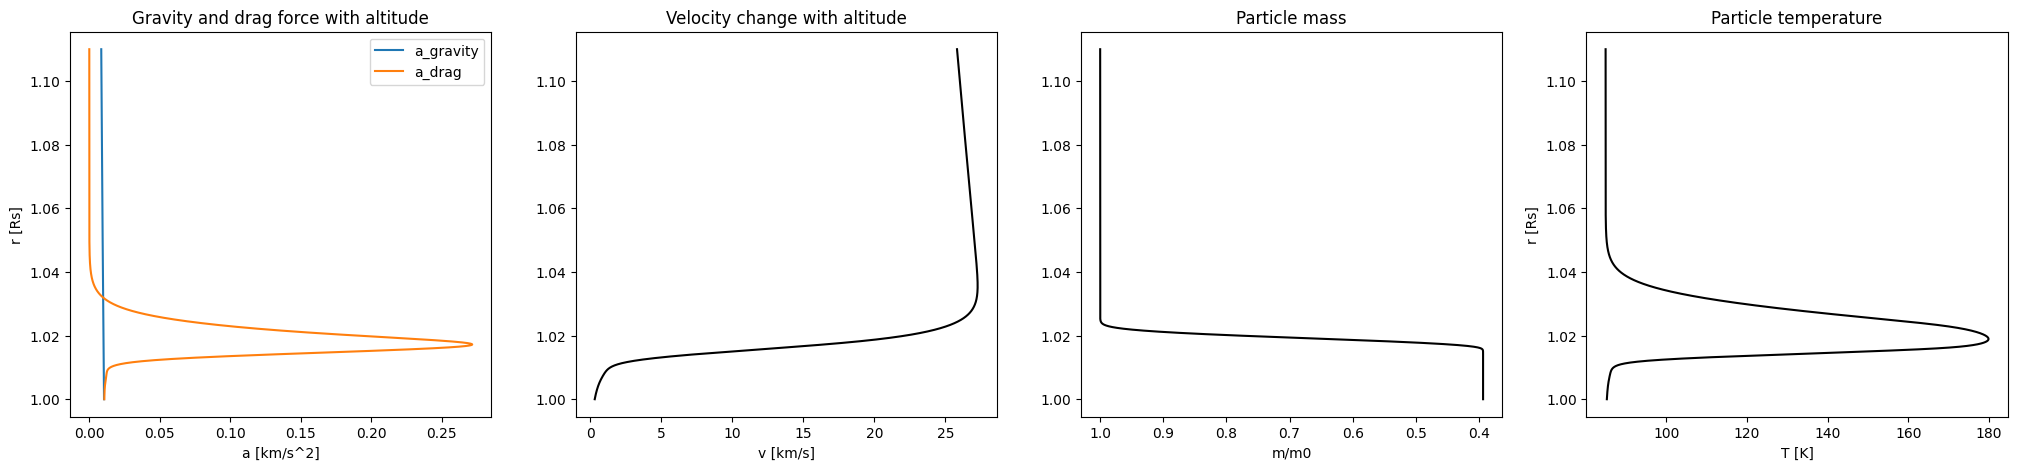

In [134]:
# using the variable axs for multiple Axes
fig, axs = plt.subplots(1, 4, figsize=(25,5))

axs[0].plot(a_gr,np.array(r[0:len(a_gr)])/Rs, label='a_gravity')
axs[0].plot(a_drag,np.array(r[0:len(a_drag)])/Rs, label='a_drag')
axs[0].set_title('Gravity and drag force with altitude')
axs[0].legend()
axs[0].set_xlabel('a [km/s^2]')
axs[0].set_ylabel('r [Rs]')

axs[1].plot(vtot,np.array(r)/Rs,'k')
axs[1].set_title('Velocity change with altitude')
axs[1].set_xlabel('v [km/s]')

axs[2].plot(np.array(m)/m00, np.array(r[0:len(m)])/Rs,'k')
axs[2].set_title('Particle mass')
axs[2].invert_xaxis()
axs[2].set_xlabel('m/m0')

axs[3].plot(T,np.array(r[0:len(T)])/Rs,'k')
axs[3].set_title('Particle temperature')
axs[3].set_xlabel('T [K]')
axs[3].set_ylabel('r [Rs]')

fig.savefig('results', dpi='figure')

Text(0, 0.5, 'Y [Rs]')

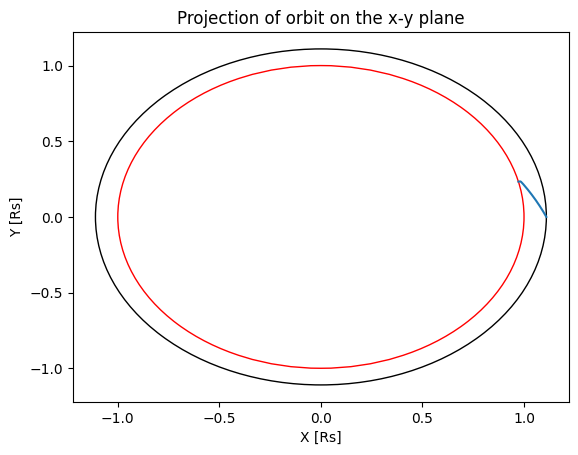

In [28]:
x=r*np.sin(th)*np.cos(phi)
y=r*np.sin(th)*np.sin(phi)
z=r*np.cos(th)
Sat=plt.Circle((0,0),Rs/Rs, color='r',fill=False)
ring=plt.Circle((0,0),R_dring/Rs, color='k',fill=False)

fig, ax = plt.subplots()
ax.plot(x/Rs,y/Rs,'-')
ax.add_patch(Sat)
ax.add_patch(ring)
#ax.set_xlim([-1.5, 1.5])
#ax.set_ylim([-1.5, 1.5])
ax.set_title('Projection of orbit on the x-y plane')
ax.set_xlabel('X [Rs]')
ax.set_ylabel('Y [Rs]')


Text(0.5, 1.0, 'Distance from surface over time')

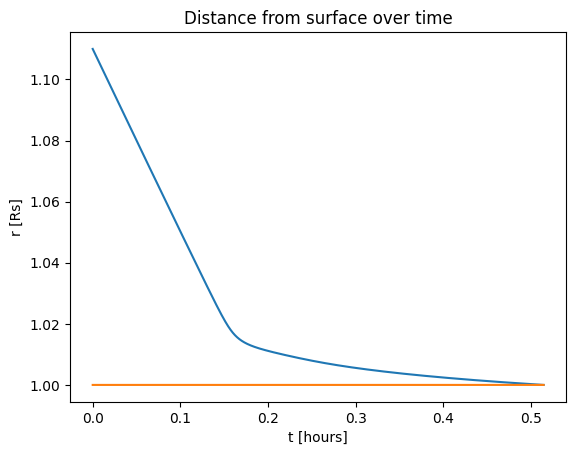

In [32]:
plt.plot(t[0:len(r)]/(60*60), [r/Rs for r in r])
plt.plot(t[0:len(r)]/(60*60), np.linspace(1, 1,len(r) ))
plt.ylabel('r [Rs]')
plt.xlabel('t [hours]')
plt.title('Distance from surface over time')